# Retrieving image cutouts from r-dropouts in SMASH


## Summary
In this notebook, we will look for objects that are detected in i and z in SMASH and in ALLWISE, but are undetected in u, g, and r.

## Image cutouts
We'll pick out some promising dropout candidates, and show how to call the Simple Image Access (SIA) service to get cutouts for them.

## Known issues
The notebook only retrieves cutouts for one object.  In order to retrieve cutouts for all candidates, the SIA service needs to be called in a loop.


### Initialization

We begin by importing the requisite libraries and getting the authorization token for the Query Client.

In [1]:
print "Start"
import numpy as np
import sys

import pandas as pd
from cStringIO import StringIO
from dl import authClient
from dl import queryClient
from pyvo.dal import sia

import matplotlib.pyplot as plt
import astropy.utils
%matplotlib inline

# Get the security token for the datalab demo user
token = authClient.login('anonymous')
print "Got token",token

Start
Got token anonymous.0.0.anon_access


### Catalog query

For our query, we will look for objects that are undetected or have large errors in u, g, and r, but are detected and have small errors in i and z.  We will only keep objects that have a match in the ALLWISE catalog.  Using subqueries to limit the object and xmatch tables using indexed columns makes the query run much faster than it would otherwise. 

In [2]:
%%time
db1='smash_dr1.object' # the SMASH object table with average magnitudes
db1sel='db1.fieldid,db1.id,db1.ra,db1.dec,db1.umag,db1.gmag,db1.rmag,db1.imag,' +\
    'db1.zmag,db1.uerr,db1.gerr,db1.rerr,db1.ierr,db1.zerr,db1.depthflag' # select ID, coordinates, and mags
db2='smash_dr1.xmatch' # the SMASH cross-match table, which contains cross-matches to ALLWISE
db2sel='db2.wise_id,db2.wise_w1mag,db2.wise_w1err,db2.wise_w2mag,db2.wise_w2err' # ALLWISE W1&W2 mags
db1where='(db1.ndetu=0 or db1.uerr>0.3) and ' + \
        ' (db1.ndetg=0 or db1.gerr>0.3) and ' + \
        ' (db1.ndetr=0 or db1.rerr>0.3) and ' + \
        ' (db1.ndeti>0 and db1.ierr<0.1) and ' + \
        ' (db1.ndetz>0 and db1.zerr<0.1)' # pick ugr dropouts
db2where='(db1.id=db2.id)' # only pick dropouts that are found in ALLWISE W1

# Create the query string.
query = 'SELECT '+db1sel+','+db2sel+' FROM (SELECT * FROM '+db1+' WHERE depthflag > 1) AS db1, '+ \
    '(SELECT * FROM '+db2+' WHERE wise_match=1) AS db2 ' +\
    'WHERE ('+db2where+' and '+db1where+')'
        
print "Your query is:", query
print "Making query"

# Call the Query Manager Service    
response = queryClient.query(token, adql = query, fmt = 'csv')
df = pd.read_csv(StringIO(response))

print len(df), "objects found."

Your query is: SELECT db1.fieldid,db1.id,db1.ra,db1.dec,db1.umag,db1.gmag,db1.rmag,db1.imag,db1.zmag,db1.uerr,db1.gerr,db1.rerr,db1.ierr,db1.zerr,db1.depthflag,db2.wise_id,db2.wise_w1mag,db2.wise_w1err,db2.wise_w2mag,db2.wise_w2err FROM (SELECT * FROM smash_dr1.object WHERE depthflag > 1) AS db1, (SELECT * FROM smash_dr1.xmatch WHERE wise_match=1) AS db2 WHERE ((db1.id=db2.id) and (db1.ndetu=0 or db1.uerr>0.3) and  (db1.ndetg=0 or db1.gerr>0.3) and  (db1.ndetr=0 or db1.rerr>0.3) and  (db1.ndeti>0 and db1.ierr<0.1) and  (db1.ndetz>0 and db1.zerr<0.1))
Making query
5769 objects found.
CPU times: user 46.9 ms, sys: 14.8 ms, total: 61.7 ms
Wall time: 39.8 s


### Examine the results

Let's look at the columns of our Pandas dataframe:

In [3]:
df.tail()

,fieldid,id,ra,dec,umag,gmag,rmag,imag,zmag,uerr,gerr,rerr,ierr,zerr,depthflag,wise_id,wise_w1mag,wise_w1err,wise_w2mag,wise_w2err
5764,143,143.606683,328.994058,-75.331512,99.99,99.99,99.9900,21.9871,21.2820,9.99,9.99,9.9900,0.076493,0.029318,3,J215558.55-751953.2,16.818,0.082,17.139,0.336
5765,66,66.174940,126.894873,-72.594395,99.99,99.99,24.4057,23.7287,22.4523,9.99,9.99,0.3013,0.075184,0.058873,2,J082734.73-723540.2,16.232,0.041,16.044,0.089
5766,20,20.554956,34.967641,-67.319301,99.99,99.99,99.9900,21.9749,20.8371,9.99,9.99,9.9900,0.030733,0.030527,3,J021952.20-671909.6,15.675,0.037,15.377,0.067
5767,57,57.446698,110.441960,-54.514229,99.99,99.99,99.9900,23.7300,22.5305,9.99,9.99,9.9900,0.099939,0.064908,2,J072146.04-543050.9,16.845,0.064,16.640,0.156
5768,19,19.418884,31.620555,-78.234641,99.99,99.99,99.9900,23.5604,22.7129,9.99,9.99,9.9900,0.099802,0.084973,2,J020628.86-781404.6,16.951,0.071,16.537,0.175


### Simple plots of the results

We'll make an z-W1, i CMD of the objects and a i-z,z-W1 color-color plot to pick out which candidates we'd like to follow up further.

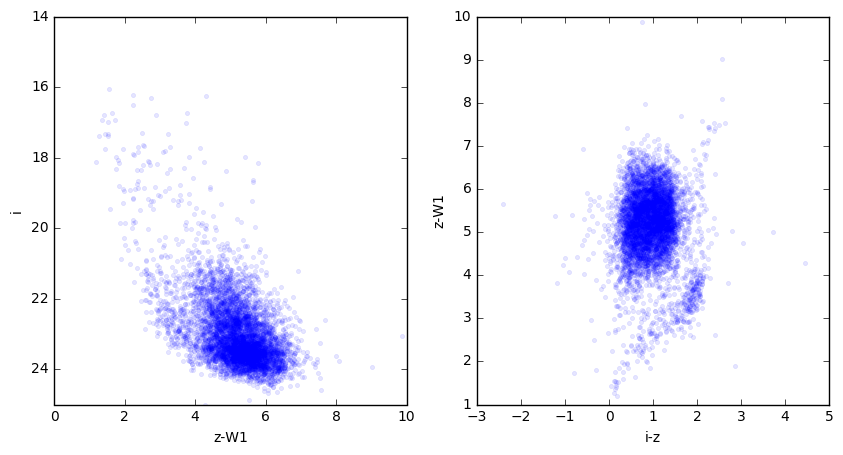

In [4]:
fig=plt.figure(figsize=(10,5))
ax1=fig.add_subplot(121)
ax2=fig.add_subplot(122)
ax1.plot(df["zmag"]-df["wise_w1mag"],df["imag"],'.',alpha=0.1)
ax1.axis([0,10,25,14])
ax1.set_xlabel('z-W1')
ax1.set_ylabel('i')

ax2.plot(df["imag"]-df["zmag"],df["zmag"]-df["wise_w1mag"],'.',alpha=0.1)
#ax2.axis([-2,4,1,8])
ax2.set_xlabel('i-z')
ax2.set_ylabel('z-W1')


### Selecting candidates

The cloud of points in both plots are probably galaxies, while stars should trace out a sequence in the color-color diagram.  Let's take a closer look at those candidates with i-z colors greater then 2.0 and z-W1 less than 4, which we think will be stars with red SEDs.

In [5]:
dfcand=df[((df["imag"]-df["zmag"])>2) & ((df["zmag"]-df["wise_w1mag"])<4)]
print len(dfcand)
dfcand.tail()

42


,fieldid,id,ra,dec,umag,gmag,rmag,imag,zmag,uerr,gerr,rerr,ierr,zerr,depthflag,wise_id,wise_w1mag,wise_w1err,wise_w2mag,wise_w2err
5502,104,104.550934,176.107300,-38.764921,99.99,99.99,99.9900,22.8623,20.8363,9.99,9.99,9.990000,0.034805,0.015223,3,J114425.78-384553.9,17.001,0.090,17.382,0.424
5526,22,22.589562,39.894183,-74.438929,99.99,99.99,99.9900,23.2871,21.1734,9.99,9.99,9.990000,0.035547,0.016528,3,J023934.56-742619.8,17.786,0.130,17.477,9999.000
5594,181,181.279342,343.462964,-78.197903,99.99,99.99,24.1645,22.6290,20.5591,9.99,9.99,0.372108,0.043736,0.016403,3,J225351.09-781152.4,16.990,0.088,16.795,0.275
5647,143,143.357304,330.078534,-76.359593,99.99,99.99,24.1651,22.9585,20.9505,9.99,9.99,0.353104,0.066035,0.017624,3,J220018.91-762134.2,17.739,0.163,17.602,0.482
5654,91,91.452798,163.335036,-42.190873,99.99,99.99,99.9900,20.9372,18.5298,9.99,9.99,9.990000,0.062298,0.093738,2,J105320.44-421127.3,15.915,0.045,16.216,0.157


### Simple Image Access setup

To use the Simple Image Access (SIA) service, we need to define the service URL and the size of the cutouts that we would like to retrieve.

In [6]:
DEF_ACCESS_URL = "http://datalab.noao.edu/sia/smash"
DEF_SIZE = 0.0085  # degrees
svc = sia.SIAService (DEF_ACCESS_URL)
size = DEF_SIZE

### Selecting one object

Let's pick off the first candidate in the list and retrieve the list of images available as a VOTable.  

In [7]:
ra1=dfcand["ra"].iloc[0]
dec1=dfcand["dec"].iloc[0]
id1=dfcand["id"].iloc[0]

images = svc.search((ra1,dec1), (size/np.cos(dec1*np.pi/180), size), verbosity=2)
print "The image list contains",images.nrecs,"entries"

The image list contains 112 entries


### Selecting the images for retrieval

We'll convert the VOTable to an AstroPy Table.  Printing the full image table shows that the SIA service finds raw, processed, resampled, and stacked images (proctype=RAW, InstCal, Resampled, or Stacked), different versions of the stacks (proctype=Stacked and prodtype=image or image1), as well as the exposure map, weight map, and data quality masks of the stacks (proctype=Stacked and prodtype=expmap, wtmap, or dqmask).  The NOAO Data Handbook and the NOAO Archive (archive.noao.edu) have explanations for the meanings of these different data products. 

In [8]:
imgTable = images.votable.to_table()
imgTable

assoc_id,access_url,access_format,access_estsize,dataproduct_type,dataproduct_subtype,calib_level,dataset_length,im_nsubarrays,im_naxes,im_naxis,im_pixtype,im_wcsaxes,im_scale,obs_title,obs_id,obs_creator_name,obs_collection,obs_creation_type,obs_creation_date,facility_name,instrument_name,obs_bandpass,obs_datasource,proposal_id,obs_publisher_did,obs_release_date,preview,target_name,target_class,s_ra,s_dec,s_fov,s_region,s_calib_status,s_resolution,em_min,em_max,em_resolution,em_res_power,t_min,t_max,t_exptime,t_resolution,o_ucd,o_unit,pol_states,object,airmass,project_code,magzero,prodtype,seeing,fwhm,file_set_id,exptime,photflag,proctype,date_obs,mjd_obs,elliptic
,,,byte,,,,,,,,,,deg,,,,,,,,,,,,,,,,,deg,deg,deg,deg,,arcs,m,m,m,,d,d,s,s,,,,,,,,,,,,,,,,,
object,object,object,int32,object,object,int64,int64,int32,int32,object,object,object,object,object,object,object,object,object,object,str1,object,object,object,object,object,object,object,object,object,float64,float64,float64,object,object,float64,float64,float64,float64,float64,float64,float64,float64,float64,object,object,object,object,object,object,object,object,object,object,object,object,object,object,object,object,object
ct4m20140602t230356,"http://dldb1.sdm.noao.edu/cutout?fileRef=c4d_140602_230520_ori.fits.fz&extn=37&POS=175.767334884,-39.3914092178&SIZE=0.0109985558489,0.0085",image/fits,413493,,,0,0,0,2,[2160 4146],,,[0.27],,ct4m20140602t230356,,2013B-0440,archival,,,DECam,r,,,ivo://noao/vo#ivoa.siav1:ivo://datalab.noao/smash_dr1/c4d_140602_230520_ori.fits.fz,,"http://dldb1.sdm.noao.edu/cutout?fileRef=c4d_140602_230520_ori.fits.fz&extn=37&POS=175.767334884,-39.3914092178&SIZE=0.0109985558489,0.0085&preview=true",,,175.79400000000001,-39.423699999999997,--,,,--,5675.0,7155.0,--,--,--,--,--,--,,,,Field104,1.02,2013B-0440,0,image,0,0,,30,,RAW,2014-06-02T23:03:56.253448,556810.96106775,0
ct4m20140602t230455,"http://dldb1.sdm.noao.edu/cutout?fileRef=c4d_140602_230648_ori.fits.fz&extn=37&POS=175.767334884,-39.3914092178&SIZE=0.0109985558489,0.0085",image/fits,398590,,,0,0,0,2,[2160 4146],,,[0.27],,ct4m20140602t230455,,2013B-0440,archival,,,DECam,g,,,ivo://noao/vo#ivoa.siav1:ivo://datalab.noao/smash_dr1/c4d_140602_230648_ori.fits.fz,,"http://dldb1.sdm.noao.edu/cutout?fileRef=c4d_140602_230648_ori.fits.fz&extn=37&POS=175.767334884,-39.3914092178&SIZE=0.0109985558489,0.0085&preview=true",,,175.79400000000001,-39.423699999999997,--,,,--,3960.0,5480.0,--,--,--,--,--,--,,,,Field104,1.02,2013B-0440,0,image,0,0,,60,,RAW,2014-06-02T23:04:55.374376,556810.96175202,0
ct4m20140602t230920,"http://dldb1.sdm.noao.edu/cutout?fileRef=c4d_140602_231111_ori.fits.fz&extn=37&POS=175.767334884,-39.3914092178&SIZE=0.0109985558489,0.0085",image/fits,531624,,,0,0,0,2,[2160 4146],,,[0.27],,ct4m20140602t230920,,2013B-0440,archival,,,DECam,z,,,ivo://noao/vo#ivoa.siav1:ivo://datalab.noao/smash_dr1/c4d_140602_231111_ori.fits.fz,,"http://dldb1.sdm.noao.edu/cutout?fileRef=c4d_140602_231111_ori.fits.fz&extn=37&POS=175.767334884,-39.3914092178&SIZE=0.0109985558489,0.0085&preview=true",,,175.79400000000001,-39.4236,--,,,--,8500.0,10020.0,--,--,--,--,--,--,,,,Field104,1.02,2013B-0440,0,image,0,0,,60,,RAW,2014-06-02T23:09:20.851020,556810.96482466,0
ct4m20140602t230752,"http://dldb1.sdm.noao.edu/cutout?fileRef=c4d_140602_230944_ori.fits.fz&extn=37&POS=175.767334884,-39.3914092178&SIZE=0.0109985558489,0.0085",image/fits,493500,,,0,0,0,2,[2160 4146],,,[0.27],,ct4m20140602t230752,,2013B-0440,archival,,,DECam,i,,,ivo://noao/vo#ivoa.siav1:ivo://datalab.noao/smash_dr1/c4d_140602_230944_ori.fits.fz,,"http://dldb1.sdm.noao.edu/cutout?fileRef=c4d_140602_230944_ori.fits.fz&extn=37&POS=175.767334884,-39.3914092178&SIZE=0.0109985558489,0.0085&preview=true",,,175.79400000000001,-39.4236,--,,,--,7100.0,8570.0,--,--,--,--,--,--,,,,Field104,1.02,2013B-0440,0,image,0,0,,60,,RAW,2014-06-02T23:07:52.956307,556810.96380736,0
ct4m20140602t235630,"http://dldb1.sdm.noao.edu/cutout?fileRef=c4d_140603_000254_ori.fits.fz&extn=37&POS=

### Narrowing down the image list

We narrow down the list by selecting only processed images with exposure times longer than 60 seconds, ignoring secondary data products like data quality masks, and make different tables for each of the r, i, and z filters.

In [9]:
rTable=imgTable[(imgTable['proctype']=='InstCal') & (imgTable['obs_bandpass']=="r") & (imgTable['prodtype']=='image') & (imgTable['exptime']>60)]
iTable=imgTable[(imgTable['proctype']=='InstCal') & (imgTable['obs_bandpass']=="i") & (imgTable['prodtype']=='image') & (imgTable['exptime']>60)]
zTable=imgTable[(imgTable['proctype']=='InstCal') & (imgTable['obs_bandpass']=="z") & (imgTable['prodtype']=='image') & (imgTable['exptime']>60)]
zTable.pprint()
iTable.pprint()
rTable.pprint()

      assoc_id      ... elliptic
                    ...         
------------------- ... --------
ct4m20140603t001436 ...        0
ct4m20140603t002037 ...        0
ct4m20140603t002638 ...        0
ct4m20140602t230920 ...        0
      assoc_id      ... elliptic
                    ...         
------------------- ... --------
ct4m20140602t235630 ...        0
ct4m20140603t000834 ...        0
ct4m20140603t000231 ...        0
ct4m20140602t230752 ...        0
      assoc_id      ... elliptic
                    ...         
------------------- ... --------
ct4m20140602t234641 ...        0
ct4m20140602t235136 ...        0
ct4m20140602t234146 ...        0
ct4m20140602t230624 ...        0
ct4m20140602t230356 ...        0


### Getting the URLs of the images

Now we pick off the URLs of the r, i, and z cutouts, and take only the first one from each potential list.

In [10]:
rurl=((rTable['preview']).data).data[0]
iurl=((iTable['preview']).data).data[0]
zurl=((zTable['preview']).data).data[0]
print 'r:',rurl
print 'i:',iurl
print 'z:',zurl

r: http://dldb1.sdm.noao.edu/cutout?fileRef=c4d_140602_235202_ooi_r_v1.fits.fz&extn=34&POS=175.767334884,-39.3914092178&SIZE=0.0109985558489,0.0085&preview=true
i: http://dldb1.sdm.noao.edu/cutout?fileRef=c4d_140603_000254_ooi_i_v1.fits.fz&extn=34&POS=175.767334884,-39.3914092178&SIZE=0.0109985558489,0.0085&preview=true
z: http://dldb1.sdm.noao.edu/cutout?fileRef=c4d_140603_002102_ooi_z_v2.fits.fz&extn=34&POS=175.767334884,-39.3914092178&SIZE=0.0109985558489,0.0085&preview=true


### Retrieving the image cutouts

Now we retrieve the cutouts.  This could be done through parallel threads to speed things up, but here we keep it simple and do it sequentially.

In [11]:
%%time
rimg = plt.imread(astropy.utils.data.download_file(rurl,cache=True,show_progress=False,timeout=120))
iimg = plt.imread(astropy.utils.data.download_file(iurl,cache=True,show_progress=False,timeout=120))
zimg = plt.imread(astropy.utils.data.download_file(zurl,cache=True,show_progress=False,timeout=120))

CPU times: user 33.9 ms, sys: 25.5 ms, total: 59.4 ms
Wall time: 6.56 s


### Displaying the cutouts

Now let's show the cutouts.  The object in question is indeed invisible in the r-band image, but is visible in both i and z, and appears point-like.

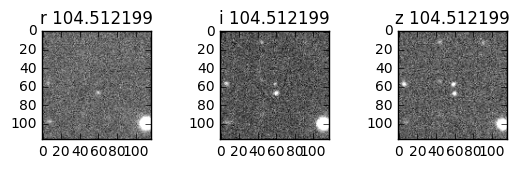

In [12]:
a1=plt.subplot2grid((2,8),(0,0),rowspan=2,colspan=2)
imgplot = plt.imshow(rimg)
a1.set_title('r '+id1.astype('string'))

a2=plt.subplot2grid((2,8),(0,3),rowspan=2,colspan=2)
imgplot = plt.imshow(iimg)
a2.set_title('i '+id1.astype('string'))

a3=plt.subplot2grid((2,8),(0,6),rowspan=2,colspan=2)
imgplot = plt.imshow(zimg)
a3.set_title('z '+id1.astype('string'))

To go through the whole list of cutouts, the code from this notebook would be best put into a Python script and run from the command line, saving the images or making a figure showing all of the candidate objects at once.